<h1>Continuum subtraction - MaNGA cube</h1>

Example of use of slicing, multi-dimension arithmetic, and smoothing.

In [15]:
# All imports used in this script
from __future__ import print_function

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.interpolate import UnivariateSpline 

from astropy.io import fits

%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 10

<h3>1 - Get raw data cube</h3>

Read cube from FITS file.

In [16]:
cube = fits.getdata('./data/manga-7443-12703-LOGCUBE.fits')
print(cube.shape)

(4563, 74, 74)


Ensure all NaN-valued pixels are zeroed before proceeding.

In [17]:
cube[np.where(np.isnan(cube))] = 0.

Display on image plane (collapse over spectral dimension).

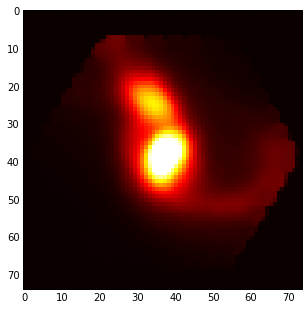

In [18]:
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()
ax.imshow(np.sum(cube,axis=0), vmax=5000, cmap=cm.hot, interpolation='nearest')

<h3>2 - Find line emission</h3>

To maximize SNR, build sum from entire cube along wavelength dimension.

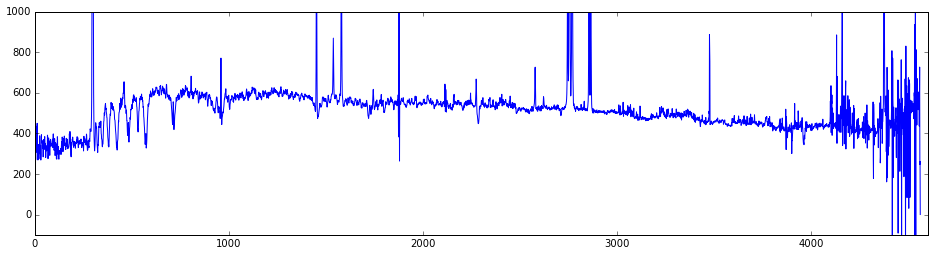

In [19]:
summed = np.sum(cube, axis=2)
summed = np.sum(summed, axis=1)

plt.gcf().set_size_inches(16.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed)

<h3>3 - Mask out emission regions </h3>

1 - Build mask that rejects wavelength ranges with emission.

2 - Use mask to build a masked data cube.

In [20]:
mask = cube.copy()
mask.fill(False)
mask[ 240: 600,:,:] = True  # these were determined by examining the plot above with a large
mask[ 670: 730,:,:] = True  # zoom factor. Some interaction is unavoidable here.
mask[ 900:1000,:,:] = True  
mask[1400:1600,:,:] = True  
mask[1870:1900,:,:] = True  
mask[2070:2100,:,:] = True  
mask[2250:2310,:,:] = True  
mask[2560:2590,:,:] = True  
mask[2700:2900,:,:] = True  
mask[3450:3500,:,:] = True  
mask[3800:4000,:,:] = True  
mask[4050:4300,:,:] = True  
mask[4310:4563,:,:] = True  

masked_cube = ma.masked_array(cube, mask=mask)

Note that we built a mask that is identical for every pixel over the entire spatial extent of the image. But the mask itself is more general and could accomodate any type of spatially-variant masking function. 

Most of the remaining code in this script assumes a spatially-invariant mask.

Note also that the mask includes some absorption lines as well.

<h3>4 - Verify that masked data cube is OK </h3>

Again, build sum for entire *masked* cube. Data in masked wavelength ranges should be absent.

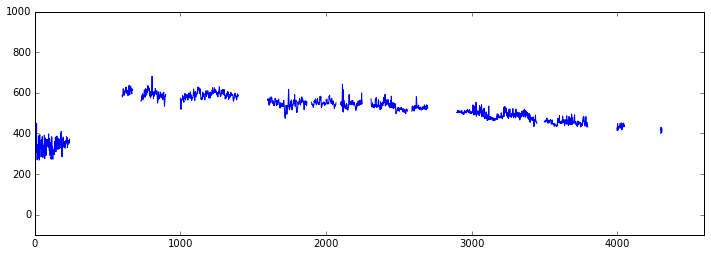

In [21]:
summed_masked = np.sum(masked_cube, axis=2)
summed_masked = np.sum(summed_masked, axis=1)

plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked)

<h3>5 - Build 1-D continuum model by interpolation-smoothing summed masked spectrum </h3>

This step will likely include some iterations to fine-tune parameters and such.

Note that the spline fit itself does not use the masked attributes of the input arrays. In the calculation below, the masked array is used only to build a weights array that effectively weights out the masked data points.

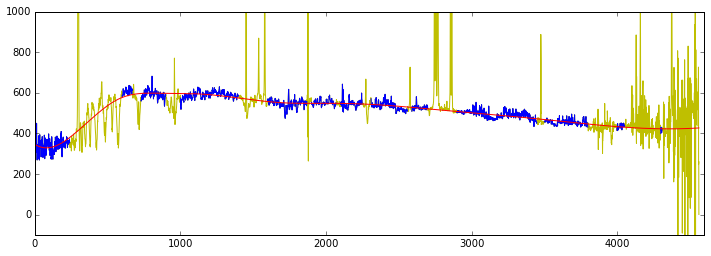

In [22]:
x = np.asarray(range(len(summed_masked)))

w = 1/summed_masked.std() 
weights = np.choose(summed_masked==0.0,(w,0.))

continuum = UnivariateSpline(x, summed, weights, s=0.04*len(weights))(x)

plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed, 'y')
plt.plot(summed_masked, 'b')
plt.plot(continuum, 'r')

<h3>6 - Subtract continuum from cube </h3>

The interpolated continuum spectrum includes the masked regions (that's the whole point of using interpolation in the first place). So we first have to build a masked version of the interpolated continuum, in order to get its flux over the unmasked regions only:

In [23]:
masked_continuum = ma.masked_array(continuum, mask=mask[:,0,0]) # in this example, any spatial pixel should do
continuum_flux = np.sum(masked_continuum)

Before subtracting the continuum from each spatial pixel, it has to be re-normalized to the flux in that spatial pixel. Note that we use the masked cube for the computation of the flux in one pixel, so it can be directly related to the flux in the masked interpolated continuum computed above.

In [24]:
continuum_subtracted_cube = np.zeros(shape=cube.shape) 
# these two loops scan the entire spatial extent of the cube. 
for i in range(cube.shape[1]):
    for j in range(cube.shape[2]):
        pixel_flux = np.sum(masked_cube[:,i,j])
        continuum_subtracted_cube[:,i,j] = cube[:,i,j] - (continuum / continuum_flux * pixel_flux)

<h3>7 - Verify results:</h3>

Apart from noise and fitting errors, the final continuum-subtracted image should contain only the flux from emission line wavelength regions (and perhaps negative flux from absorption lines if they were included in the mask). 

In [25]:
print(np.min(continuum_subtracted_cube))
print(np.max(continuum_subtracted_cube))

-1.90532301488
58.356576154


In [26]:
print(np.min(np.sum(continuum_subtracted_cube, axis=0)))
print(np.max(np.sum(continuum_subtracted_cube, axis=0)))

-51.3599226673
859.107531854


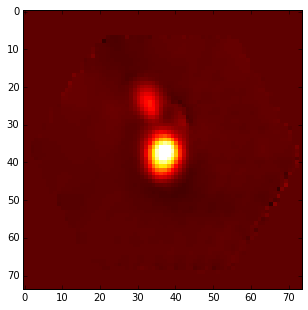

In [27]:
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()
ax.imshow(np.sum(continuum_subtracted_cube, axis=0), vmin=-100, vmax=700, cmap=cm.hot, interpolation='nearest')

We can verify that globally the cube had its continuum removed by plotting its spectrum over the entire spatial extent of the cube:

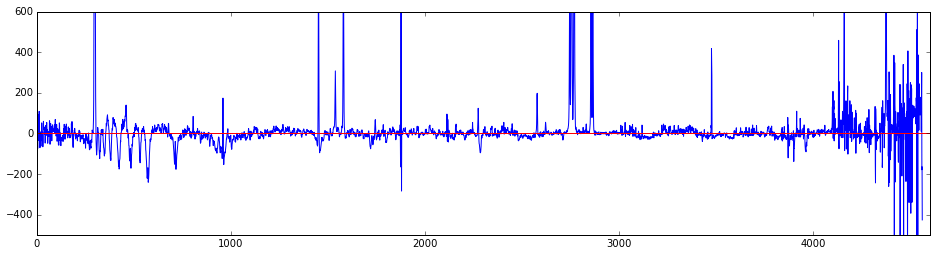

In [28]:
summed_cs = np.sum(continuum_subtracted_cube, axis=2)
summed_cs = np.sum(summed_cs, axis=1)

plt.gcf().set_size_inches(16.,4.)
plt.axis([0.,4600.,-500.,600.])
plt.plot(summed_cs)
plt.plot([0.,4600.], [0., 0.], 'r')